# Kaggle Competition - Season 4 Episode 11

## Initial look at data

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [130]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
og = pd.read_csv('./final_depression_dataset_1.csv')
train.head()

id      Name  Gender   Age           City Working Professional or Student  \
0   0  Aaradhya  Female  49.0       Ludhiana            Working Professional   
1   1     Vivan    Male  26.0       Varanasi            Working Professional   
2   2    Yuvraj    Male  33.0  Visakhapatnam                         Student   
3   3    Yuvraj    Male  22.0         Mumbai            Working Professional   
4   4      Rhea  Female  30.0         Kanpur            Working Professional   

         Profession  Academic Pressure  Work Pressure  CGPA  \
0              Chef                NaN            5.0   NaN   
1           Teacher                NaN            4.0   NaN   
2               NaN                5.0            NaN  8.97   
3           Teacher                NaN            5.0   NaN   
4  Business Analyst                NaN            1.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0                 NaN               2.0  More than 8 hours        Healthy   
1                 NaN               3.0  Less than 5 hours      Unhealthy   
2                 2.0               NaN          5-6 hours        Healthy   
3                 NaN               1.0  Less than 5 hours       Moderate   
4                 NaN               1.0          5-6 hours      Unhealthy   

    Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
0      BHM                                    No               1.0   
1      LLB                                   Yes               7.0   
2  B.Pharm                                   Yes               3.0   
3      BBA                                   Yes              10.0   
4      BBA                                   Yes               9.0   

   Financial Stress Family History of Mental Illness  Depression  
0               2.0                               No           0  
1               3.0                               No           1  
2               1.0                               No           1  
3               1.0                              Yes           1  
4               4.0                              Yes           0

In [131]:
print(f'Size of train data: {train.shape}')
print(f'Size of test data: {test.shape}')
print(f'Size of og data: {og.shape}')

Size of train data: (140700, 20)
Size of test data: (93800, 19)
Size of og data: (2556, 19)


Checking for unique values for every feature

In [132]:
unique_vals_df = pd.DataFrame({'train': train.nunique(), 'test': test.nunique(), 'og': og.nunique()})
unique_vals_df

train     test     og
Academic Pressure                           5      5.0    5.0
Age                                        43     44.0   43.0
CGPA                                      331    326.0  312.0
City                                       98     68.0   30.0
Degree                                    115     87.0   27.0
Depression                                  2      NaN    2.0
Dietary Habits                             23     22.0    3.0
Family History of Mental Illness            2      2.0    2.0
Financial Stress                            5      5.0    5.0
Gender                                      2      2.0    2.0
Have you ever had suicidal thoughts ?       2      2.0    2.0
Job Satisfaction                            5      5.0    5.0
Name                                      422    374.0  216.0
Profession                                 64     64.0   35.0
Sleep Duration                             36     31.0    4.0
Study Satisfaction                          5      5.0    5.0
Work Pressure                               5      5.0    5.0
Work/Study Hours                           13     13.0   13.0
Working Professional or Student             2      2.0    2.0
id                                     140700  93800.0    NaN

In [133]:
dropping_cols = ['id','Name', 'Academic Pressure', 'CGPA', 'Study Satisfaction']  #Removed the last three features since they have a lot of missing values
# Check if columns exist in the dataframe before dropping them to safegaurd against repeated runs
dropping_cols = [col for col in dropping_cols if col in train.columns]
train.drop(dropping_cols, inplace=True, axis=1)
test.drop(dropping_cols, inplace=True, axis=1)
og.drop(dropping_cols[1:], inplace=True, axis=1)

Create a copy of the dataframe

In [134]:
temp_og = og.copy()
temp_test = test.copy()
temp_train = train.copy()

In [135]:
train.isnull().sum()

Gender                                       0
Age                                          0
City                                         0
Working Professional or Student              0
Profession                               36630
Work Pressure                            27918
Job Satisfaction                         27910
Sleep Duration                               0
Dietary Habits                               4
Degree                                       2
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             4
Family History of Mental Illness             0
Depression                                   0
dtype: int64

## Explore the data

### Clean features

##### For degree

In [136]:
import re

# We need to clean this list
def clean_string(input_string):
    return re.sub(r'[^a-z0-9]', '', str(input_string).lower())

og_degree_list = og['Degree'].unique()
og_degree_list = [clean_string(x) for x in og_degree_list]

In [137]:
# Now, I will first clean the Degree column in the train and test dataframes
train['Degree'] = train['Degree'].apply(lambda x: clean_string(x))
test['Degree'] = test['Degree'].apply(lambda x: clean_string(x))
og['Degree'] = og['Degree'].apply(lambda x: clean_string(x))

#Now, I will replace the values in the Degree column in the train and test dataframes with null values if they are not in the final_degree_list
train['Degree'] = train['Degree'].apply(lambda x: x if x in og_degree_list else None)
test['Degree'] = test['Degree'].apply(lambda x: x if x in og_degree_list else None)
og['Degree'] = og['Degree'].apply(lambda x: x if x in og_degree_list else None)

##### For Profession

In [138]:
og_profession_list = set(og['Profession'].unique())

# Now, I will first clean the Profession column in the train and test dataframes
train['Profession'] = train['Profession'].apply(lambda x: clean_string(x))
test['Profession'] = test['Profession'].apply(lambda x: clean_string(x))

#Now, I will replace the values in the Profession column in the train and test dataframes with null values if they are not in the og_profession_list
train['Profession'] = train['Profession'].apply(lambda x: x if x in og_profession_list else None)
test['Profession'] = test['Profession'].apply(lambda x: x if x in og_profession_list else None)

##### Age

In [139]:
# Convert the 'Age' column in the 'train' dataframe to integer type
train['Age'] = train['Age'].astype(int)
test['Age'] = test['Age'].astype(int)
og['Age'] = og['Age'].astype(int)

##### City

In [140]:
#Lets check the city now
#Since we reliably know that the citys in og dataset are correct, we check for the ones that are not present

# exclusive_train_city_list = train['City'].unique()[~np.isin(train['City'].unique(), og['City'].unique())]
# exclusive_test_city_list = test['City'].unique()[~np.isin(test['City'].unique(), og['City'].unique())]
#We didnt include them since they were mostly fabricated
final_city_list = set(og['City'].unique()).union(['Gurgaon'])

#Now, I will first clean the City column in the train and test dataframes
train['City'] = train['City'].apply(lambda x: x if x in final_city_list else None)
test['City'] = test['City'].apply(lambda x: x if x in final_city_list else None)
og['City'] = og['City'].apply(lambda x: x if x in final_city_list else None)

##### Sleep duration

In [141]:
og_sleep_list = og['Sleep Duration'].unique()

#Now, I will replace the values in the Sleep Duration column in the train and test dataframes with null values if they are not in the og_sleep_list
train['Sleep Duration'] = train['Sleep Duration'].apply(lambda x: x if x in og_sleep_list else None)
test['Sleep Duration'] = test['Sleep Duration'].apply(lambda x: x if x in og_sleep_list else None)

##### Dietary Habits

In [142]:
#Now, I will replace the values in the Sleep Duration column in the train and test dataframes with null values if they are not in the og_sleep_list

og_diet_list = og['Dietary Habits'].unique()

#Now, I will replace the values in the Dietary Habits column in the train and test dataframes with null values if they are not in the og_diet_list
train['Dietary Habits'] = train['Dietary Habits'].apply(lambda x: x if x in og_diet_list else None)
test['Dietary Habits'] = test['Dietary Habits'].apply(lambda x: x if x in og_diet_list else None)

##### Coverting binary cat cols to boolean

In [143]:
train.rename(columns={'Have you ever had suicidal thoughts ?' : 'Suicidal Thoughts', 'Gender' : 'is_male', 'Working Professional or Student' : 'is_student', 'Family History of Mental Illness' : 'history_mental_illness' }, inplace=True)

test.rename(columns={'Have you ever had suicidal thoughts ?' : 'Suicidal Thoughts', 'Gender' : 'is_male', 'Working Professional or Student' : 'is_student', 'Family History of Mental Illness' : 'history_mental_illness' }, inplace=True)

og.rename(columns={'Have you ever had suicidal thoughts ?' : 'Suicidal Thoughts', 'Gender' : 'is_male', 'Working Professional or Student' : 'is_student', 'Family History of Mental Illness' : 'history_mental_illness' }, inplace=True)

In [144]:
#Now convert binary cat cols to 0 and 1
train['Suicidal Thoughts'] = train['Suicidal Thoughts'].apply(lambda x: 1 if x == 'Yes' else 0)
test['Suicidal Thoughts'] = test['Suicidal Thoughts'].apply(lambda x: 1 if x == 'Yes' else 0)
og['Suicidal Thoughts'] = og['Suicidal Thoughts'].apply(lambda x: 1 if x == 'Yes' else 0)

train['is_male'] = train['is_male'].apply(lambda x : 1 if x == 'Male' else 0)
test['is_male'] = test['is_male'].apply(lambda x : 1 if x == 'Male' else 0)
og['is_male'] = og['is_male'].apply(lambda x : 1 if x == 'Male' else 0)

train['is_student'] = train['is_student'].apply(lambda x : 1 if x == 'Student' else 0)
test['is_student'] = test['is_student'].apply(lambda x : 1 if x == 'Student' else 0)
og['is_student'] = og['is_student'].apply(lambda x : 1 if x == 'Student' else 0)

train['history_mental_illness'] = train['history_mental_illness'].apply(lambda x : 1 if x == 'Yes' else 0)
test['history_mental_illness'] = test['history_mental_illness'].apply(lambda x : 1 if x == 'Yes' else 0)
og['history_mental_illness'] = og['history_mental_illness'].apply(lambda x : 1 if x == 'Yes' else 0)

### Missing values

In [151]:
#Dataframe of missing values
#Checking missing values
missing_vals_df = pd.DataFrame({'train': train.isnull().sum().loc[train.isnull().sum()> 0], 
                                'test': test.isnull().sum().loc[test.isnull().sum()> 0], 
                                'og': og.isnull().sum().loc[og.isnull().sum()> 0]
                                })

missing_vals_df

train   test   og
Profession        140393  93600  673
Work Pressure      27827  18728  502
Job Satisfaction   27819  18724  502

Check the nature of these cols

- Degree - Categorical
- Profession - Categorical
- Work pressure - Numerical
- Job satisfaction - Numerical
- Dietary Habits - Categorical
- Financial Stress - Numerical    


Redundancy to check for enough records after dropping missing values

In [146]:
#Check whether there are enough records to train the model
# train_without_names = train.drop(['Name', 'id'], axis=1)
# number_of_duplicates = train_without_names.duplicated().sum()

#### Drop missing value entries with low frequency

Degree, Dietary Habits, Financial Stress have low missing values. These can be dropped.

In [150]:
low_missing_cols = ['Degree', 'Dietary Habits', 'Financial Stress', 'City', 'Sleep Duration']
low_missing_cols_train = [col for col in low_missing_cols if col in train.columns]
low_missing_cols_test = [col for col in low_missing_cols if col in train.columns]
train = train.dropna(subset=low_missing_cols)
test = test.dropna(subset=low_missing_cols)

#### Dealing with missing value entries with high frequency

Axes(0.125,0.11;0.62x0.77)


d:\Anaconda\anafiles\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
d:\Anaconda\anafiles\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


is_male  Age  is_student  Work Pressure  \
is_male                     NaN  NaN         NaN            NaN   
Age                         NaN  NaN         NaN            NaN   
is_student                  NaN  NaN         NaN            NaN   
Work Pressure               NaN  NaN         NaN            NaN   
Job Satisfaction            NaN  NaN         NaN            NaN   
Suicidal Thoughts           NaN  NaN         NaN            NaN   
Work/Study Hours            NaN  NaN         NaN            NaN   
Financial Stress            NaN  NaN         NaN            NaN   
history_mental_illness      NaN  NaN         NaN            NaN   
Depression                  NaN  NaN         NaN            NaN   

                        Job Satisfaction  Suicidal Thoughts  Work/Study Hours  \
is_male                              NaN                NaN               NaN   
Age                                  NaN                NaN               NaN   
is_student                           NaN                NaN               NaN   
Work Pressure                        NaN                NaN               NaN   
Job Satisfaction                     NaN                NaN               NaN   
Suicidal Thoughts                    NaN                NaN               NaN   
Work/Study Hours                     NaN                NaN               NaN   
Financial Stress                     NaN                NaN               NaN   
history_mental_illness               NaN                NaN               NaN   
Depression                           NaN                NaN               NaN   

                        Financial Stress  history_mental_illness  Depression  
is_male                              NaN                     NaN         NaN  
Age                                  NaN                     NaN         NaN  
is_student                           NaN                     NaN         NaN  
Work Pressure                        NaN                     NaN         NaN  
Job Satisfaction                     NaN                     NaN         NaN  
Suicidal Thoughts                    NaN                     NaN         NaN  
Work/Study Hours                     NaN                     NaN         NaN  
Financial Stress                     NaN                     NaN         NaN  
history_mental_illness               NaN                     NaN         NaN  
Depression                           NaN                     NaN         NaN

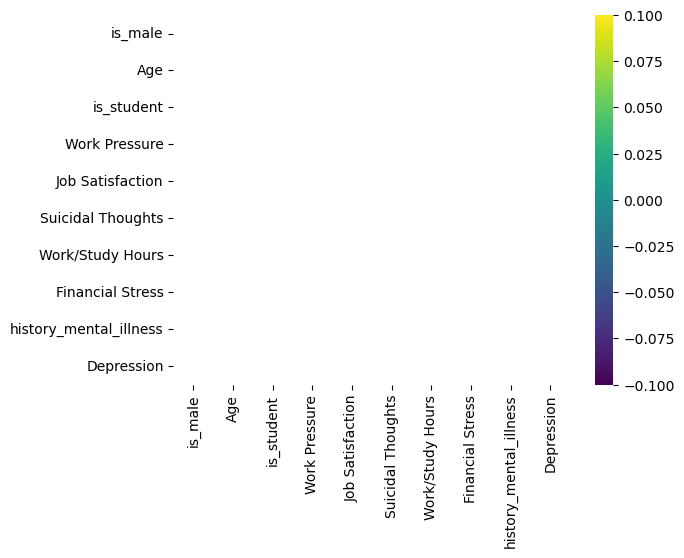

In [148]:
#To deal with cols with high frequency of null tuples
train.isnull().sum()
# train.columns
temp_train = train.copy() #Making a copy for safety purposes

#The plan is to check for corr between the numerical cols and then subsequently with the 'Profession' feature
temp_train.dropna(axis=0, inplace=True, how='any')         #Remove any tuples with null values - simplify the corr process
# lol = temp_train.groupby('Profession')
corr_with_target = temp_train.select_dtypes(exclude=['object'])
corr_without_target = temp_train.select_dtypes(exclude=['object']).drop('Depression', axis=1)


print(sns.heatmap(corr_with_target.corr(), cmap = 'viridis'))
corr_with_target.corr()

In [149]:
#There are rows with the same profession as the name
#We need to remove these first
no_rows_prof_equal = train[train['Name'] == train['Profession']]['id'].count()   #6
#Since there are only six rows with same name as profession, we can drop them as well
train = train[train['Name'] != train['Profession']]

KeyError: 'Name'